In [1]:
using Distributions;
using Images;

---

## Parameters
As in the preprint Supp Table 1. A few from the experimental setup are missing.

In [2]:
const dt::Float64 = 0.1
const N_trials::Int = 10000
const T::Int = 100;

In [3]:
const N_out::Int = 13
const N_latent::Int = 30
const p0::Float64 = 0.04
const p::Float64 = 0.2
const q::Float64 = 0.15

const N::Int = N_out + N_latent;

In [4]:
const E1::Float64 = -70
const E_exc::Float64 = 0
const E_inh::Float64 = -75
const gl::Float64 = 0.1
const g_den::Float64 = 2.0
const g_exc_0::Float64 = 0.3
const g_inh_0::Float64 = 6.0
const a::Float64 = 0.3
const b::Float64 = -58.
d_den_init = Uniform(5., 15.)
d_som_init = Uniform(5., 15.)
const delta::Float64 = 25.

rho(u) = 1. / (1. + exp(a*(b-u)))

d_den::Vector{Float64} = round.(rand(d_den_init, N), digits=1)
d_som_exc::Vector{Float64} = round.(rand(d_som_init, N), digits=1)
d_som_inh::Vector{Float64} = d_som_exc .+ delta;


In [5]:
const η0::Float64 = 0.0001
const ηl::Float64 = 0.001
const λ::Float64 = 0.6
W_init = Normal(0., 0.5)

lrs::Matrix{Float64} = mapreduce(permutedims, vcat, [[(i<=N_out && j<=N_out) ? η0 : ηl for j in 1:N] for i in 1:N]); #ugly, but necessary for not checking if i<N_out etc in step

Since you did this nice analysis, might as well: 

In [6]:
P(k) = (k == 0) ? p0 : (1-p0) * p^((k^2-k)/2) * (1-p^k)
D_nout = DiscreteNonParametric(0:N_latent, P.(0:N_latent));

---

## Somato-somatic scafold

Just an implementation of what is described in the paper. I did check if $d_{out}$ follow the correct distribution. Could certainly be better but this is by no mean a bottleneck. I just have the feeling that it might be overly complex for no practical reason.

In [7]:
B::Matrix{Float64} = zeros(N_latent, N)
fatigued = []
nudged = vcat(1:N_out)
latent = vcat(N_out+1:N)
previously_accepted = Dict(i=>0 for i in latent)
while !isempty(nudged)
    i = rand(nudged)
    X = rand(D_nout)
    for c in 1:X
        j = rand(latent)
        while rand() > q^previously_accepted[j] || j==i
            j = rand(latent)
        end
        previously_accepted[j] += 1
        (j in fatigued || j in nudged) || push!(nudged, j)
        B[j-N_out,i] = 1
    end
    deleteat!(nudged, findall(nudged.==i))
    push!(fatigued, i)
end

---

## Memory

Here I took a shitty approach in term of memory, but it makes things easier in terms of later indexing. I use 3 `Vector{Queue{Float64}}`, one for each delay type (dendritic, somatic excitatory, somatic inhibitory). Within a `Vector{Queue{Float64}}` for one type of delay, I start by filling in all the queues with $d_i/\texttt{dt}$ initial values. Then at every step I use `pop!` once on every queue to get my delayed values, and at the end I `push!` once to every queue the current $r_i$ to the queue. In that sense, I do not need to index an history to get the delayed values, rather the length of each queue acts as the delay. Indexing a complete history is probably better, I just thought this was a funny implementation, and it shouldn't be much slower on CPU to be honest. Bellow are the functions that create and add to the queues. The `pop!` are in the `step!` function bellow.

_In fact these are implemented as `Vector{Vector{Float64}}` because Julia has no implementation of `Queue` that is better than `push!(::Vector{Float64}, ::Float64)` and `popfirst!(::Vector{Float64})` but that's a detail._



In [8]:
function create_queues!(ds::Vector{Float64})::Vector{Vector{Float64}}
    qs = [Vector{Float64}() for _ in 1:N]
    initialize!((q,d)) = (x->push!(q,x)).(rho.(E1*ones(Int(d ÷ dt))))
    initialize!.(zip(qs, ds))
    return qs
end;

In [9]:
function memory!(r::Vector{Float64})
    for (q_den, q_exc, q_inh, x) in zip(m_den, m_som_exc, m_som_inh, r)
        push!(q_den, x)
        push!(q_exc, x)
        push!(q_inh, x)
    end
end;

---

## Step

Quite straightforwardly implementing the equations. Here I did try to not be too dirty, as I don't want to wait for hours afterwards. 
I first do the (3) matrix multiplications that I found useful in implementing the equations. I then do the assignments in loops as it is the more performant way to do things in Julia on CPU. The 2 matrix multplications for somato-somatic synapses might be better as indexing...
The structure is: 
```julia
for output neurons
    intrinsic u update
    if teacher
        teacher nudging
    end
end
for latent neurons
    u update
end
for all neurons # this could be done twice in the previous loops ... 
    v update    # ... but it's ugly
    rbar update
end
update memory # it has been rolled already by the pop! in the u and v updates!
for all somato-dendritic weights
    plasticity
end
```
This function `step!` is benchmarked at the end of this notebook, and on my hardware (cpu) takes around 4μs, so that's for dt ms of simulations. In other words, we are at approximatively 25x 'real'time.

In [10]:
function step!(u::Vector{Float64},u_tgt::Vector{Float64},v::Vector{Float64},rbar::Vector{Float64},W::Matrix{Float64};teacher::Bool=true)
    past_den_r = popfirst!.(m_den)
    I_den = W * past_den_r
    g_exc = g_exc_0 * B * max.(popfirst!.(m_som_exc), rho(E1))
    g_inh = g_inh_0 * B * min.(popfirst!.(m_som_inh), rho(E1))
    for i in 1:N_out
        @inbounds u[i] += dt * (-gl*(v[i] .- E1) + g_den*(v[i]-u[i])) 
        if teacher 
            @inbounds u[i] += dt * (λ/(1-λ) * (gl+g_den) / (E_inh - E_exc)) * ((E_inh - u_tgt[i]) * (E_exc - u[i]) + (u_tgt[i]-E_exc) * (E_inh - u[i]))
        end
    end
    for i in N_out+1:N
        @inbounds u[i] += dt * (-gl*(v[i] .- E1) + g_den*(v[i]-u[i]) + g_exc[i-N_out] * (E_exc - u[i]) + g_inh[i-N_out] * (E_inh - u[i]))
    end
    for i in 1:N
        @inbounds v[i] += dt * (-gl*(v[i] .- E1) + I_den[i])
        @inbounds rbar[i] += dt * (-gl*rbar[i] .+ ((gl*g_den)/(gl+g_den)) * past_den_r[i])
    end
    r = rho.(u)
    rstar = rho.((g_den/(gl+g_den))*v.+(gl*E1)/(gl+g_den))
    memory!(r)
    for i in 1:N, j in 1:N
        @inbounds W[i,j] += dt*lrs[i,j]*(r[i]-rstar[i])*rbar[j]
    end
    return nothing;
end;

---

In [11]:
function train!(u::Vector{Float64}, v::Vector{Float64}, rbar::Vector{Float64}, W::Matrix{Float64}, target::Function, T::Int, n_trials::Int; test_every::Int=1000, θ::Float64=-60., dt::Float64=0.1)
    for trial in 0:n_trials-1
        for t in 0:dt:T-dt
            step!(u, target(t), v, rbar, W, teacher=true)
        end
        (trial % test_every == 0) && test!(u, v, rbar, W, T, dt=dt, θ=θ)
    end
end

train! (generic function with 1 method)

---

## Testing and plotting

I was quite proud of my idea of showing in black the times where the produced/replayed output agrees with the target and then in two different colors when only the target or the produced output was on. Then I remembered that Ben presented something like this at the Xmas symposium last year ahah. Anyway that's what I do for testing, much quantitative. See plot bellow produced by `train!` (in fact, by the calls of `test!` in `train!`).

In [12]:
function test!(u::Vector{Float64}, v::Vector{Float64}, rbar::Vector{Float64}, W::Matrix{Float64}, T::Int; dt::Float64=0.1, θ::Float64=-60)
    u_prod = Vector{Vector{Float64}}()
    for t in 0:dt:T-dt
        step!(u, zeros(N_out), v, rbar, W, teacher=false)
        isinteger(t) && push!(u_prod, u[1:N_out])
    end
    check(vv) = reduce(hcat, vv) .> θ
    display(colors[1 .+ 2*check(u_prod) + check([target(t) for t in 0:T-1])])
end
colors = [colorant"white", colorant"red", colorant"cyan", colorant"black"];

---

## Variables and target

In [13]:
v::Vector{Float64} = E1*ones(N)
u::Vector{Float64} = E1*ones(N)
rbar::Vector{Float64} = rho.(u);
W::Matrix{Float64} = rand(W_init, N, N);

In [14]:
m_den::Vector{Vector{Float64}} = create_queues!(d_den)
m_som_exc::Vector{Vector{Float64}} = create_queues!(d_som_exc)
m_som_inh::Vector{Vector{Float64}} = create_queues!(d_som_inh);

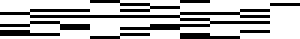

In [15]:
chords = [rand(N_out).>.75 for j in 1:10]
target(t) = E1*ones(N_out) + 20*Float64.(chords[Int(t÷10+1)]);
broadcast.(Gray, (!).(mapreduce(permutedims,vcat,repeat(chords, inner=10))'))

---

Bellow, red is target only, cyan is produced only, black is both, white is neither

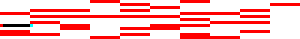

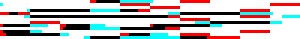

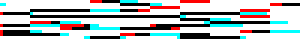

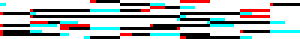

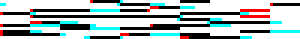

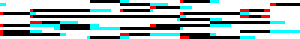

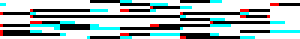

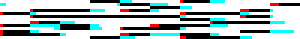

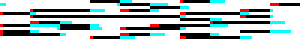

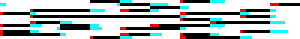

In [16]:
train!(u, v, rbar, W, target, T, N_trials)

---

In [17]:
using BenchmarkTools
u_tgt_bench::Vector{Float64} = E1*ones(N_out) + 20*Float64.(rand(N_out).<.5);
@benchmark step!($u, $u_tgt_bench, $v, $rbar, $W)

BenchmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  3.623 μs …  1.525 ms  ┊ GC (min … max): 0.00% … 99.19%
 Time  (median):     3.895 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.617 μs ± 20.368 μs  ┊ GC (mean ± σ):  6.19% ±  1.40%

    ▁█▇▁                                                      
  ▂▃████▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▆█▇▄▃▃▄▆▆▅▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂ ▃
  3.62 μs        Histogram: frequency by time        5.64 μs <

 Memory estimate: 3.33 KiB, allocs estimate: 18.